In [2]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [3]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [4]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_80_20.csv')
data_val = pd.read_csv('../../Data Splits/val_data_80_20.csv')

In [5]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [7]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [8]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

In [9]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('gridsearch', GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [1, 10, 100, 1000],
                                          'penalty': ['l2'],
                                          'solver': ['lbfgs', 'liblinear']},
                              scoring='accuracy'))])

In [10]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'].best_estimator_, '../../Models/70-30 Test/pipeline_lr_best_estimator.joblib')


['../Models/80-20 Test/pipeline_lr_best_estimator.joblib']

In [11]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 94.93%


In [12]:

steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=LogisticRegression(C=1000,
                                                                       solver='liblinear')))])

[1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0
 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1
 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0
 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0
 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 

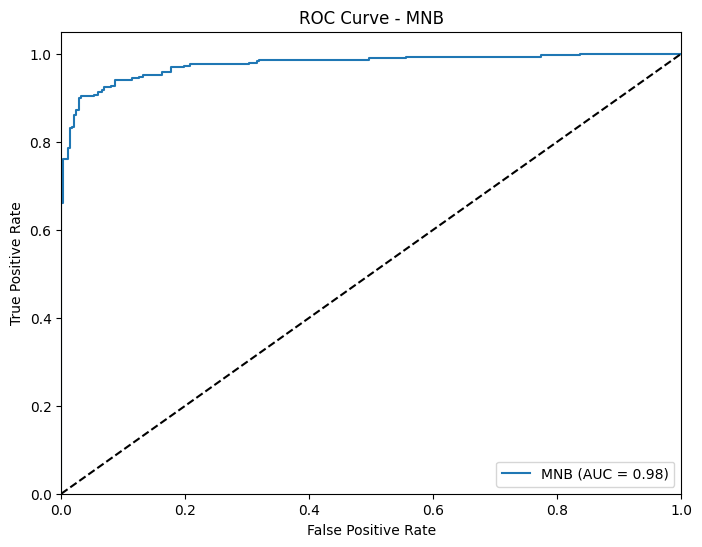

[1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0
 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1
 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1
 1 1 1 0 0 1 1 0 1 1 0 1 

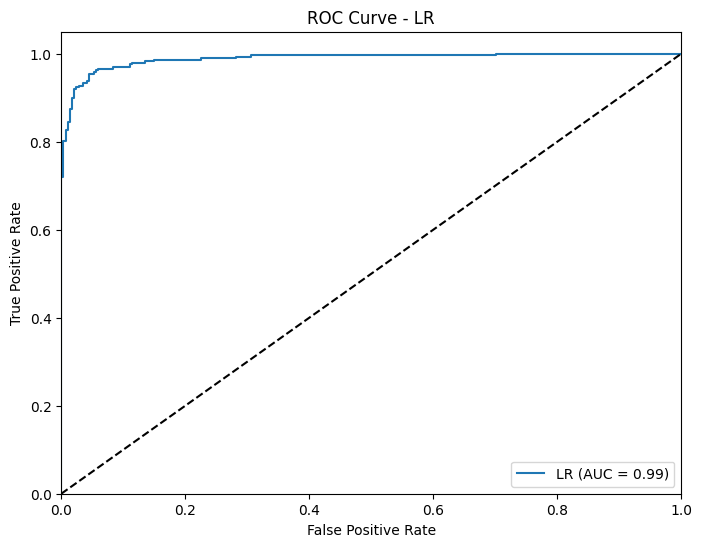

[1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0
 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1
 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 0 1 1 0 0 1 0 1 

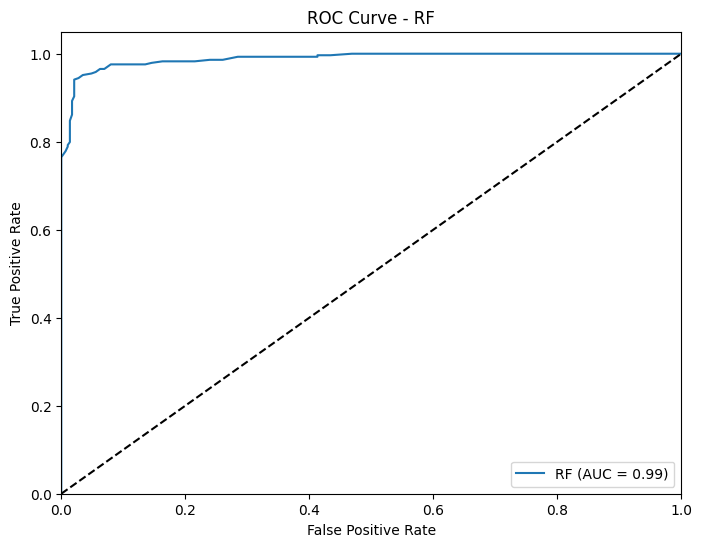

[1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0
 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1
 1 1 1 1 0 1 1 0 1 0 0 1 

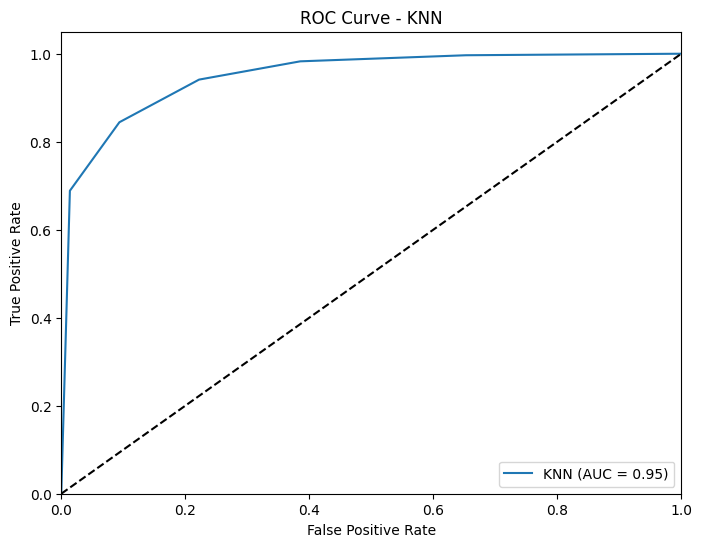

[1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1
 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1
 1 1 1 0 0 1 1 0 1 1 0 1 

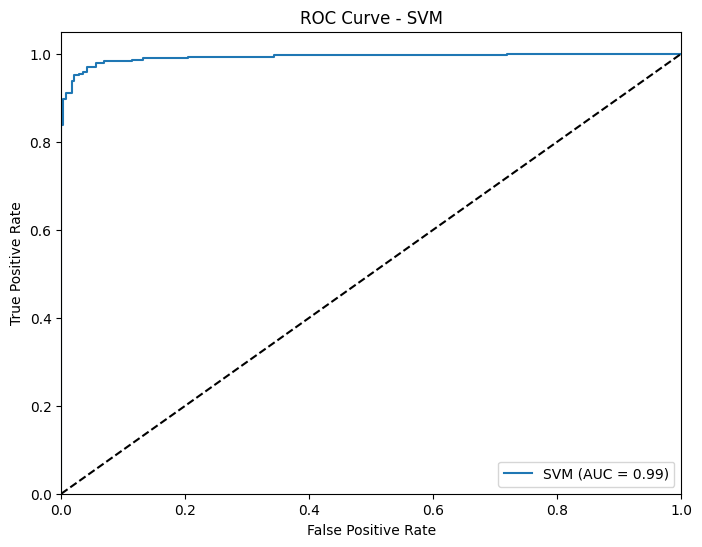

In [22]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9722703639514731
Precision: 0.975609756097561
Recall: 0.9688581314878892
F1 Score: 0.9722222222222222
AUC: 0.9946174548250672
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       288
           1       0.98      0.97      0.97       289

    accuracy                           0.97       577
   macro avg       0.97      0.97      0.97       577
weighted avg       0.97      0.97      0.97       577



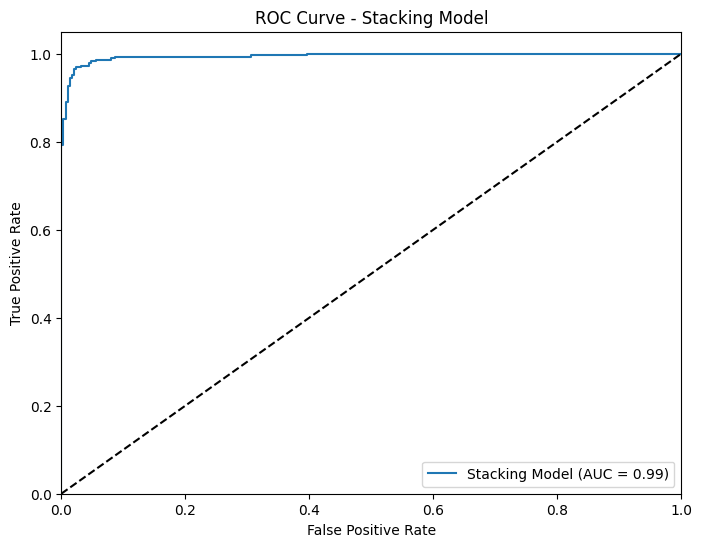

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.850953  0.781163  0.975779  0.867692  0.976115
LR              0.948007  0.974359  0.920415  0.946619  0.988478
RF              0.953206  0.951724  0.955017  0.953368  0.988826
KNN             0.859619  0.809524  0.941176    0.8704  0.948872
SVM             0.954939  0.981685  0.927336  0.953737  0.992227
Stacking Model   0.97227   0.97561  0.968858  0.972222  0.994617


In [23]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [15]:
# Save the model using joblib
joblib.dump(stack, '../../Models/70-30 Test/pipeline_lr.joblib')

['../Models/80-20 Test/pipeline_lr.joblib']